# Assignment 2 - Machine Learning
## FEUP MIEIC - Inteligência Artificial *(EIC0029/IART)*



## Decision Tree partial notebook

This Jupyter Notebook implpementes and documents a Decision Tree machine Learning model. <br><br>
*The content of this notebook will be also included in the complete notebook named **IART-MachineLearning.ipynb** that can be found in the root directory of this repository*

***

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

database = "database.sqlite"
con = sqlite3.connect(database)
pd.set_option('display.max_columns', None)

matches_df = pd.read_sql("""SELECT * from MATCH""", con)
teams_df = pd.read_sql("""SELECT * from TEAM""", con)
player_attributes_df = pd.read_sql("""SELECT * from PLAYER_ATTRIBUTES""", con)
team_attributes_df = pd.read_sql("""SELECT * from TEAM_ATTRIBUTES""", con)

home_players = ["home_player_" + str(x) for x in range(1, 12)]
away_players = ["away_player_" + str(x) for x in range(1, 12)]

matches_kept_columns = ["id", "league_id", "date", "home_team_api_id", "away_team_api_id", "home_team_goal", "away_team_goal"]
matches_kept_columns = matches_kept_columns + home_players
matches_kept_columns = matches_kept_columns + away_players

matches_df = matches_df[matches_kept_columns]

for player in home_players:
    matches_df = pd.merge(matches_df, player_attributes_df[["id", "overall_rating"]], left_on=[player], right_on=["id"], suffixes=["", "_" + player])
for player in away_players:
    matches_df = pd.merge(matches_df, player_attributes_df[["id", "overall_rating"]], left_on=[player], right_on=["id"], suffixes=["", "_" + player])
 
matches_df = matches_df.rename(columns={"overall_rating": "overall_rating_home_player_1"})

matches_df['overall_rating_home'] = matches_df[['overall_rating_' + p for p in home_players]].sum(axis=1)
matches_df['overall_rating_away'] = matches_df[['overall_rating_' + p for p in away_players]].sum(axis=1)
matches_df['overall_rating_difference'] = matches_df['overall_rating_home'] - matches_df['overall_rating_away']

matches_df['mean_overall_rating_home'] = matches_df[['overall_rating_' + p for p in home_players]].mean(axis=1)
matches_df['mean_overall_rating_away'] = matches_df[['overall_rating_' + p for p in away_players]].mean(axis=1)

matches_df['min_overall_rating_home'] = matches_df[['overall_rating_' + p for p in home_players]].min(axis=1)
matches_df['min_overall_rating_away'] = matches_df[['overall_rating_' + p for p in away_players]].min(axis=1)

matches_df['max_overall_rating_home'] = matches_df[['overall_rating_' + p for p in home_players]].max(axis=1)
matches_df['max_overall_rating_away'] = matches_df[['overall_rating_' + p for p in away_players]].max(axis=1)


for c in matches_df.columns:
    if '_player_' in c:
        matches_df = matches_df.drop(c, axis=1)

#function to calculate last 5 games performance
def last5(team_id, date, match_t):
     
    mat = match_t[(match_t['date'] < date)]
    mat = mat[mat['home_team_api_id'] == team_id]
    
    mat5 = mat.head(5)
    if len(mat5.index) < 5:
        return -1
    mat5['Home result'] = 0
    mat5['Home result'] = np.where(mat5['home_team_goal'] > mat5['away_team_goal'], 3, mat5['Home result'])
    mat5['Home result'] = np.where(mat5['home_team_goal'] == mat5['away_team_goal'], 1, mat5['Home result'])
    total = mat5['Home result'].sum()
    return total

match_t = matches_df[['home_team_api_id', 'away_team_api_id','date', 'home_team_goal', 'away_team_goal']].copy()
match_t['date'] = pd.to_datetime(match_t['date'])
match_t.sort_values(by=['date'], inplace=True, ascending=False) 
matches_df['Home_last5'] = 0
matches_df['Away_last5'] = 0
perc = 0
for i in matches_df.index:
    Htotal = last5(match_t['home_team_api_id'].iloc[i], match_t['date'].iloc[i], match_t)
    Atotal = last5(match_t['away_team_api_id'].iloc[i], match_t['date'].iloc[i], match_t)
    matches_df['Home_last5'].values[i] = Htotal
    matches_df['Away_last5'].values[i] = Atotal
    if i % 655 == 0:
        perc += 10
        print(perc, "%", end=" ")

matches_aux = pd.read_sql("""SELECT * FROM MATCH""" ,con)

#Select all bet columns (removed PSA, PSH, PSD because they are almost all NaN)
bet_columns = ["B365H", "B365A", "B365D", "BWH", "BWD", "BWA", "IWH", "IWD", "IWA", "LBH", "LBD", "LBA", "WHH", "WHD", "WHA", "SJH", "SJD", "SJA", "VCH", "VCD", "VCA", "GBH", "GBD", "GBA", "BSH", "BSD", "BSA"]

#Get specific columns for bets on home and draw
bet_columns_home = ["B365H", "BWH","IWH", "LBH", "WHH", "SJH", "VCH", "GBH","BSH"]
bet_columns_draw = ["B365D", "BWD","IWD", "LBD", "WHD", "SJD", "VCD", "GBD","BSD"]
bet_columns_away = ["B365A", "BWA","IWA", "LBA", "WHA", "SJA", "VCA", "GBA","BSA"]

#Calculate mean values for bets on home team and draw. Add these values to match table
matches_df['mean_bets_home'] = matches_aux[bet_columns_home].mean(axis=1)
matches_df['mean_bets_draw'] = matches_aux[bet_columns_draw].mean(axis=1)
matches_df['mean_bets_away'] = matches_aux[bet_columns_away].mean(axis=1)

#Replace NaN values (on bets) with mean values 
matches_df.fillna(matches_df.mean(), inplace=True)
matches_df.isnull().sum()

#Get goal difference
matches_df['goal_diff'] = matches_df['home_team_goal'] - matches_df['away_team_goal']

matches_df['Game Result'] = 'Defeat'
matches_df['Game Result'] = np.where(matches_df['goal_diff'] == 0, 'Draw', matches_df['Game Result'])
matches_df['Game Result'] = np.where(matches_df['goal_diff'] > 0, 'Win', matches_df['Game Result'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

10 % 20 % 30 % 40 % 50 % 60 % 70 % 80 % 90 % 100 % 

In [2]:
matches_df = matches_df.drop(['id', 'date', 'home_team_api_id','away_team_api_id','home_team_goal','away_team_goal', 'goal_diff'], axis=1)
matches_df = matches_df.drop(['min_overall_rating_away', 'min_overall_rating_home', 'max_overall_rating_home', 'max_overall_rating_away','away_team_api_id','home_team_goal','away_team_goal', 'goal_diff'], axis=1)

matches_df

,league_id,overall_rating_home,overall_rating_away,overall_rating_difference,mean_overall_rating_home,mean_overall_rating_away,min_overall_rating_home,min_overall_rating_away,max_overall_rating_home,max_overall_rating_away,Home_last5,Away_last5,mean_bets_home,mean_bets_draw,mean_bets_away,Game Result
0,7809,746.0,783.0,-37.0,67.818182,71.181818,60.0,63.0,77.0,92.0,1,1,1.765556,3.322222,4.164444,Draw
1,7809,772.0,790.0,-18.0,70.181818,71.818182,58.0,63.0,92.0,92.0,8,11,1.898889,3.250000,3.616667,Defeat
2,7809,780.0,719.0,61.0,70.909091,71.900000,62.0,62.0,76.0,92.0,9,8,2.462222,3.233333,2.544444,Win
3,7809,688.0,717.0,-29.0,68.800000,71.700000,58.0,62.0,83.0,92.0,8,3,1.438889,3.805556,6.533333,Draw
4,7809,733.0,770.0,-37.0,66.636364,70.000000,60.0,60.0,74.0,92.0,8,-1,4.494444,3.422222,1.674444,Win
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6537,19694,772.0,780.0,-8.0,70.181818,70.909091,62.0,67.0,84.0,79.0,-1,-1,2.044444,3.144444,3.943333,Win
6538,19694,755.0,720.0,35.0,68.636364,65.454545,57.0,48.0,84.0,72.0,-1,-1,2.284444,3.097778,3.338889,Defeat
6539,17642,752.0,779.0,-27.0,68.363636,70.818182,62.0,62.0,77.0,82.0,-1,-1,2.282222,3.066667,3.355556,Win
6540,13274,682.0,755.0,-73.0,68.200000,68.636364,56.0,59.0,78.0,74.0,-1,-1,2.515556,3.100000,2.914444,Win


In [28]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split


y = matches_df['Game Result']
X = matches_df.drop('Game Result', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)


# apply regular SMOTE
#method = SMOTE()
X, y = SMOTE().fit_sample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=y)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

parameters = {'max_depth': range(5,50),
              'criterion': ['gini', 'entropy'],
              'splitter' : ['random', 'best']
             }

clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=-1, cv=5)

clf.fit(X=X_train_scaled, y=y_train)

tree_model = clf.best_estimator_

print (clf.best_score_, clf.best_params_) 

0.4448485253819733 {'criterion': 'gini', 'max_depth': 32, 'splitter': 'random'}


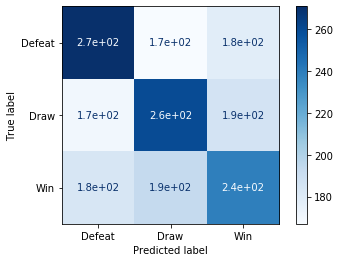

In [29]:
disp = plot_confusion_matrix(tree_model, X_test_scaled, y_test, cmap=plt.cm.Blues)

In [30]:
y_pred = tree_model.predict(X_test_scaled)

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Defeat       0.43      0.44      0.44       616
        Draw       0.42      0.42      0.42       616
         Win       0.40      0.39      0.39       616

    accuracy                           0.42      1848
   macro avg       0.42      0.42      0.42      1848
weighted avg       0.42      0.42      0.42      1848

